## <u>**Use the "Text" blocks to provide explanations wherever you find them necessary. Highlight your answers inside these text fields to ensure that we don't miss it while grading your HW.**</u> 

## **Setup**

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and uploading it to your drive), you can skip this section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# First mount your drive before running these cells. 
# Create a folder for the this HW and change to that dir
%cd /content/drive/MyDrive/CSE 519 - Fall 2021/Assignment-3


/content/drive/MyDrive/CSE 519 - Fall 2021/Assignment-3


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
# Create a new API token under "Account" in the kaggle webpage and download the json file
# Upload the file by clicking on the browse 
files.upload()

{}

In [ ]:
%cp kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions download -c  rossmann-store-sales --force

100% 44.0k/44.0k [00:00<00:00, 181kB/s]

100% 310k/310k [00:00<00:00, 928kB/s]

100% 192k/192k [00:00<00:00, 602kB/s]

 15% 1.00M/6.71M [00:00<00:02, 2.57MB/s]
100% 6.71M/6.71M [00:00<00:00, 13.6MB/s]


In [ ]:
%ls

kaggle.json  sample_submission.csv  store.csv  test.csv.zip  train.csv.zip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## **Section 1: Library and Data Imports (Q1)**

- Import your libraries and read the data into a dataframe. Print the head of the dataframe. 

In [ ]:
#fill in dtypes dict for efficient memory utilization
dtypes_train = {
          'Store':          'uint16', 
          'DayOfWeek':      'uint8',
          'Date':           'category',
          'Sales':          'uint16',
          'Customers':      'uint16',
          'Open':           'uint8',
          'Promo':          'uint8',
          'StateHoliday':   'category',
          'SchoolHoliday':  'uint8'
        }

dtypes_store = {
                'StoreType':                    'category',
                'Assortment':                   'category',
                'CompetitionDistance':          'float32', #distance cannot be negative
                'CompetitionOpenSinceMonth':    'float16',
                'CompetitionOpenSinceYear':     'float16',
                'Promo2':                       'uint8',
                'Promo2SinceWeek':              'float16',
                'Promo2SinceYear':              'float16',
                'PromoInterval':                'category'
                }

In [ ]:
df_train_data = pd.read_csv('/content/drive/MyDrive/CSE 519 - Fall 2021/Assignment-3/train.csv.zip', dtype = dtypes_train)
df_store_data = pd.read_csv('/content/drive/MyDrive/CSE 519 - Fall 2021/Assignment-3/store.csv', dtype = dtypes_store)

#Merging the dataframes
df_merged = pd.merge(df_train_data, df_store_data, how="left", on="Store")

print("Size of merged dataframe: ", df_merged.shape)
print("Printing the head of merged dataframe: \n")
df_merged.head()

Size of merged dataframe:  (1017209, 18)
Printing the head of merged dataframe: 



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
del df_train_data, df_store_data

In [ ]:
#Change datatype of Date column to datetime 
df_merged['Date'] = df_merged['Date'].astype('datetime64[ns]') 

# **Preprocessing on training data (will be used in Q8 too)**
1.   If store is not open (i.e. Open = 0 ), then ideally no sales should occur, so we can remove those rows after verification as below. 
2.   Now, check if there are stores on which no sales occur even if the store was open. We can safely remove those rows as well because our final prediction column 'Sales' has no data and therefore, will have minimal impact, if any.
3.   Check for columns having null values and fill those columns. 6 columns in store dataset have null values. I have filled 0 values for 4 of these columns having null values (CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear). And filled the mean values for column CompetitionDistance.
4. Created a function for category encoding. This will help us to fill the null values in PromoInterval column as well.
5. Separate out the numerical and categorical columns for further analysis and training through regression models.


In [ ]:
def category_encoding(df, column):
  if df[column].dtype.name == 'category':
    print("categorical column:", column)
    df[column] = df[column].cat.codes
  else:
    print("do nothing")

In [ ]:
df_preprocess = df_merged.copy()

In [ ]:
#Preprocessing on merged data, #1 - Since sales column has zero values for all 172817 rows on which store was closed, we can remove these.
print("Number of stores that are closed and as expected have zero sales:", df_preprocess[(df_preprocess.Open == 0) & (df_preprocess.Sales == 0)]['Store'].count())

#preprocessing #2, if store is open and sales are zero, then 
print("Number of stores that are open and have zero sales: ",df_preprocess[(df_preprocess.Open != 0) & (df_preprocess.Sales == 0)]['Store'].count())

df_preprocess = df_preprocess[(df_preprocess.Open !=0 ) & (df_preprocess.Sales > 0)]

#preprocessing #3, we can see that 6 columns in store dataset have null values
print("Percentage null values for columns: \n",df_preprocess.isnull().sum() / df_preprocess.shape[0] * 100)
df_preprocess['CompetitionDistance'] = df_preprocess['CompetitionDistance'].fillna(df_preprocess['CompetitionDistance'].mean())

#Below operation shows if 'Promo2' == 0, then values for 3 columns: (Promo2SinceWeek, Promo2SinceYear, PromoInterval) are null.
df_preprocess.loc[df_preprocess['Promo2'] == 0, ['Promo2SinceWeek', 'Promo2SinceYear']] = 0
df_preprocess['CompetitionOpenSinceMonth'] = df_preprocess['CompetitionOpenSinceMonth'].fillna(0)
df_preprocess['CompetitionOpenSinceYear'] = df_preprocess['CompetitionOpenSinceYear'].fillna(0)

#preprocessing #4, Calling function to encode 'PromoInterval' column
category_encoding(df_preprocess, 'PromoInterval')
df_preprocess[df_preprocess['PromoInterval'] == -1]['PromoInterval'] = 0

#preprocessing #5, separating the numerical and categorical columns
numerical = df_preprocess.select_dtypes(exclude=["category","object","datetime64[ns]"])
categorical = df_preprocess.select_dtypes(include=["category","object"])
df_preprocess.isnull().sum()

Number of stores that are closed and as expected have zero sales: 172817
Number of stores that are open and have zero sales:  54
Percentage null values for columns: 
 Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.258901
CompetitionOpenSinceMonth    31.811905
CompetitionOpenSinceYear     31.811905
Promo2                        0.000000
Promo2SinceWeek              50.133004
Promo2SinceYear              50.133004
PromoInterval                50.133004
dtype: float64
categorical column: PromoInterval


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [ ]:
#Decomposing the Date variable into individual days, weeks, months
df_preprocess["year"] = df_preprocess["Date"].dt.year
df_preprocess["month"] = df_preprocess["Date"].dt.month
df_preprocess["day"] = df_preprocess["Date"].dt.day
df_preprocess["week_of_year"] = df_preprocess["Date"].dt.isocalendar().week
df_preprocess["year_week"] = df_preprocess["Date"].dt.strftime("%Y-%W")

## **Section 2: Effect of Holidays (Q2)**

**Ques 2 - Analysis and Observations**.

- Here, the holiday column is: StateHoliday.
- StateHoliday has 4 values: 0 (NoHoliday), a(Public), b(Easter), c(Christmas).
- In the given dataset, christmas holiday has been considered on 2 days: 25th Dec and 26th Dec (in year 2013 and 2014). Easter holiday has been considered on 4 days i.e. in 2013 : (29 March to 1st April) in 2014: (18th April to 21st April) in 2015: (3rd April to 6th April)
- From the graph below (first one), I have plotted a bar graph showing the average sales during and before each of above 5 holidays. 
- **It can been seen that the sales have increased before Christmas holidays and have decreased during holidays (week 52).**
- For Easter, the trend seems to be opposite where Sales have increased during the holidays. This can be due to the fact that Easter holidays are more than any other type of holidays, so more days can results in larger number of average sales.

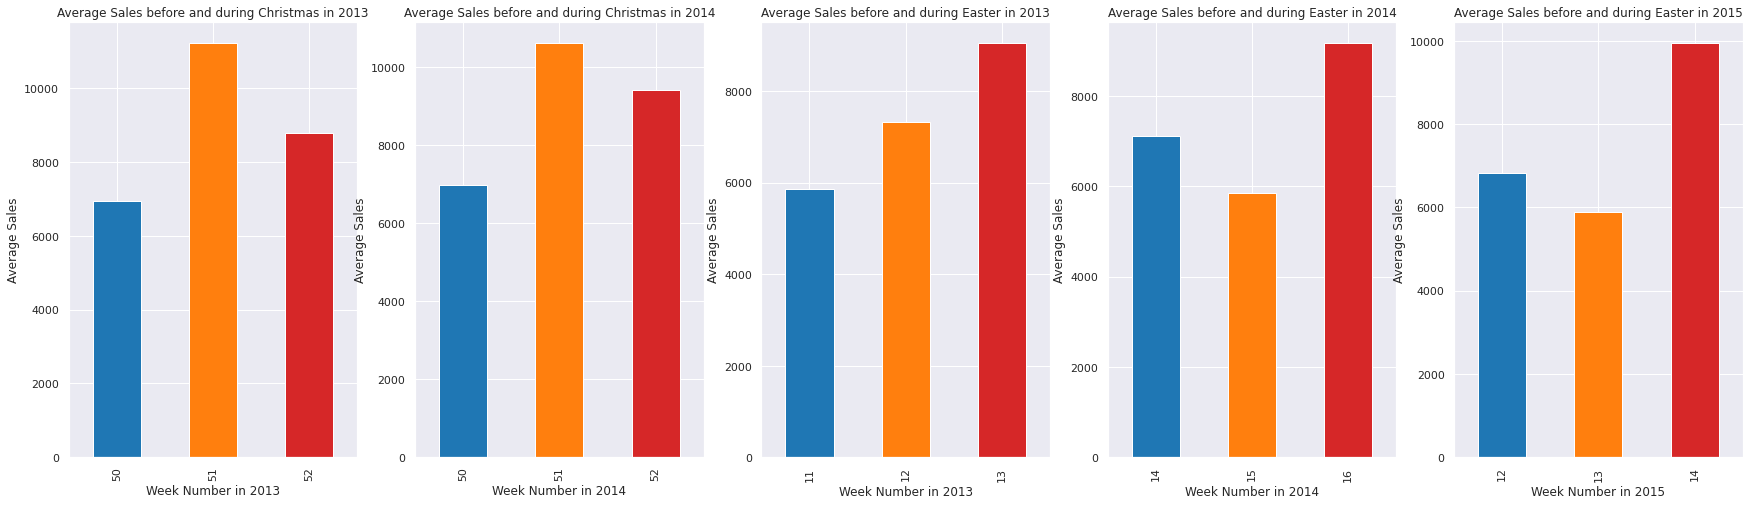

In [ ]:
plt.figure(figsize = (30,8))
sns.set(font_scale = 1)
plt.subplot(1, 5, 1)
df_preprocess[(df_preprocess.Date < '2013-12-27') & (df_preprocess.Date > '2013-12-10')].groupby('week_of_year')['Sales'].mean().plot.bar( ylabel= 'Average Sales', xlabel='Week Number in 2013',
                                                               title ='Average Sales before and during Christmas in 2013',
                                                               color = ['#1f77b4', '#ff7f0e',  '#d62728', '#9467bd'])

plt.subplot(1, 5, 2)
df_preprocess[(df_preprocess.Date < '2014-12-27') & (df_preprocess.Date > '2014-12-10')].groupby('week_of_year')['Sales'].mean().plot.bar( ylabel= 'Average Sales', xlabel='Week Number in 2014',
                                                               title ='Average Sales before and during Christmas in 2014',
                                                               color = ['#1f77b4', '#ff7f0e',  '#d62728', '#9467bd'])


plt.subplot(1, 5, 3)
df_preprocess[(df_preprocess.Date < '2013-04-01') & (df_preprocess.Date > '2013-03-15')].groupby('week_of_year')['Sales'].mean().plot.bar( ylabel= 'Average Sales', xlabel='Week Number in 2013',
                                                               title ='Average Sales before and during Easter in 2013',
                                                               color = ['#1f77b4', '#ff7f0e',  '#d62728', '#9467bd'])

plt.subplot(1, 5, 4)
df_preprocess[(df_preprocess.Date < '2014-04-21') & (df_preprocess.Date > '2014-04-01')].groupby('week_of_year')['Sales'].mean().plot.bar( ylabel= 'Average Sales', xlabel='Week Number in 2014',
                                                               title ='Average Sales before and during Easter in 2014',
                                                               color = ['#1f77b4', '#ff7f0e',  '#d62728', '#9467bd'])

plt.subplot(1, 5, 5)
df_preprocess[(df_preprocess.Date < '2015-04-06') & (df_preprocess.Date > '2015-03-18')].groupby('week_of_year')['Sales'].mean().plot.bar( ylabel= 'Average Sales', xlabel='Week Number in 2015',
                                                               title ='Average Sales before and during Easter in 2015',
                                                               color = ['#1f77b4', '#ff7f0e',  '#d62728', '#9467bd'])

## **Section 3: Most and Least selling stores (Q3a & Q3b)**

For this, I have calculated the stores with highest and lowest cumulative sales in the first part.

**Stores IDs with Highest Cumulative Sales:** [251, 1114, 562, 817, 262]

**Stores IDs with Lowest Cumulative Sales:**  [307, 543, 198, 208, 263]


In [ ]:
#it seems all the stores have sales data of more than 6 months
print(((df_preprocess.groupby('Store')['Date'].count()) > 186).value_counts())

df_highest = pd.DataFrame(df_preprocess.groupby('Store')['Sales'].sum().sort_values().tail(5).reset_index())
print("List of store IDs with highest cumulative sales data: \n",list(df_highest['Store']))
df_lowest = pd.DataFrame(df_preprocess.groupby('Store')['Sales'].sum().sort_values().head(5).reset_index())
print("List of store IDs with lowest cumulative sales data: \n",list(df_lowest['Store']))

True    1115
Name: Date, dtype: int64
List of store IDs with highest cumulative sales data: 
 [251, 1114, 562, 817, 262]
List of store IDs with lowest cumulative sales data: 
 [307, 543, 198, 208, 263]


**Q3 A)**

---


(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130]), <a list of 14 Text major ticklabel objects>)

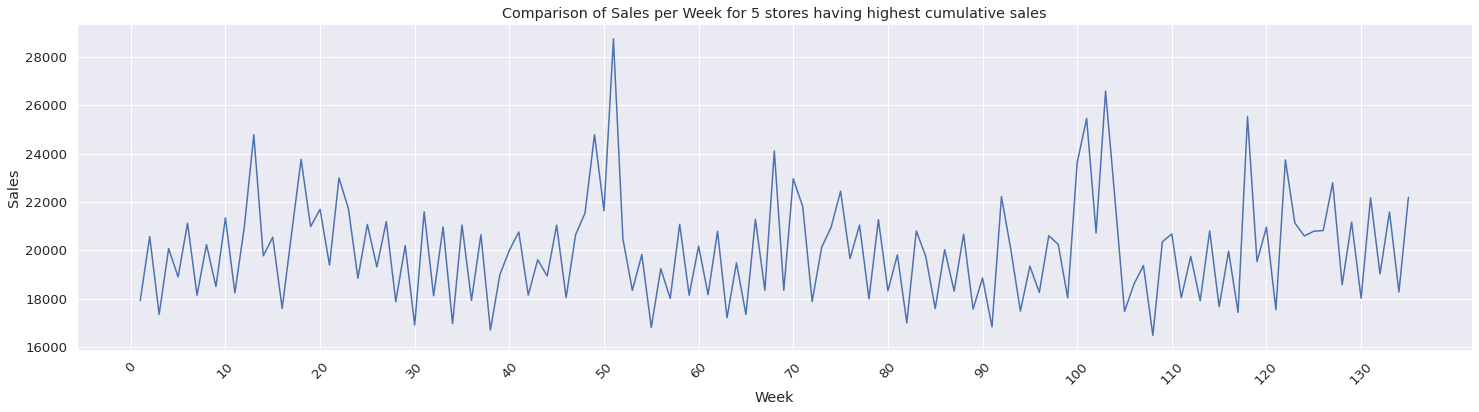

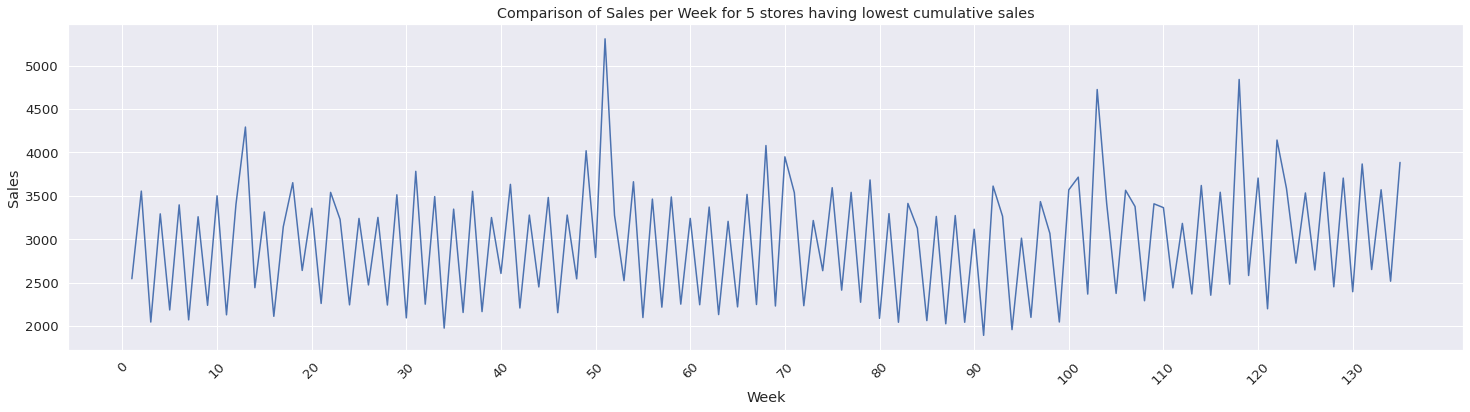

In [ ]:
#For stores with highest cumulative sales
sales_2013 = df_preprocess[(df_preprocess['year'] == 2013 ) & (df_preprocess['Store'].isin(list(df_highest['Store'])))].groupby('week_of_year')['Sales'].mean()
sales_2014 = df_preprocess[(df_preprocess['year'] == 2014 ) & (df_preprocess['Store'].isin(list(df_highest['Store'])))].groupby('week_of_year')['Sales'].mean()
sales_2015 = df_preprocess[(df_preprocess['year'] == 2015 ) & (df_preprocess['Store'].isin(list(df_highest['Store'])))].groupby('week_of_year')['Sales'].mean()

sales_per_week = pd.DataFrame(pd.concat([sales_2013, sales_2014, sales_2015], ignore_index = True))
sales_per_week.index += 1
sales_per_week = sales_per_week.reset_index().rename(columns={'index':'Week'})

plt.figure(figsize=(25,6))
sns.set(font_scale = 1.2)
plot = sns.lineplot(x="Week", y="Sales", data=sales_per_week)
plot.set_title("Comparison of Sales per Week for 5 stores having highest cumulative sales")
plot.set_xticks(range(0, int(sales_per_week.Week.max()), 10))
plt.xticks(rotation=45)

#For stores with lowest cumulative sales
sales_2013_low = df_preprocess[(df_preprocess['year'] == 2013 ) & (df_preprocess['Store'].isin(list(df_lowest['Store'])))].groupby('week_of_year')['Sales'].mean()
sales_2014_low = df_preprocess[(df_preprocess['year'] == 2014 ) & (df_preprocess['Store'].isin(list(df_lowest['Store'])))].groupby('week_of_year')['Sales'].mean()
sales_2015_low = df_preprocess[(df_preprocess['year'] == 2015 ) & (df_preprocess['Store'].isin(list(df_lowest['Store'])))].groupby('week_of_year')['Sales'].mean()

sales_per_week_low = pd.DataFrame(pd.concat([sales_2013_low, sales_2014_low, sales_2015_low], ignore_index = True))
sales_per_week_low.index += 1
sales_per_week_low = sales_per_week_low.reset_index().rename(columns={'index':'Week'})


plt.figure(figsize=(25,6))
#plt.subplot(1, 1, 1)
sns.set(font_scale = 1.2)
plot = sns.lineplot(x="Week", y="Sales", data=sales_per_week_low)
plot.set_title("Comparison of Sales per Week for 5 stores having lowest cumulative sales")
plot.set_xticks(range(0, int(sales_per_week_low.Week.max()), 10))
plt.xticks(rotation=45)


In [ ]:
print("Week with maximum Sales(stores with highest cumulative sales): \n",sales_per_week[sales_per_week.Sales == sales_per_week.Sales.max()])
print("\nWeek with minimum Sales(stores with highest cumulative sales): \n ",sales_per_week[sales_per_week.Sales == sales_per_week.Sales.min()])
print("\nWeek with maximum Sales(stores with lowest cumulative sales): \n",sales_per_week_low[sales_per_week_low.Sales == sales_per_week_low.Sales.max()])
print("\nWeek with minimum Sales(stores with lowest cumulative sales): \n",sales_per_week_low[sales_per_week_low.Sales == sales_per_week_low.Sales.min()])

Week with maximum Sales(stores with highest cumulative sales): 
     Week        Sales
50    51  28748.65625

Week with minimum Sales(stores with highest cumulative sales): 
       Week        Sales
107   108  16480.84375

Week with maximum Sales(stores with lowest cumulative sales): 
     Week        Sales
50    51  5307.933333

Week with minimum Sales(stores with lowest cumulative sales): 
     Week        Sales
90    91  1894.791667


**Observations:**

---
1. Here, I have plotted Sales per week graphs for 5 stores with highest cumulative sales(Say Scenario 1) and 5 stores with lowest cumulative sales (Say Scenario 2).
2. For both Scenarios 1 and 2, the maximum Sales occured during Week 51. This can be expected as Week 51 is the second last week of the year, a week before Christmas holidays. So, it is likely that people will go out and purchase items from Stores.
3. It can also be seen that the Sales generally increases just before the holidays and then dips during the holidays. This can be seen as a general trend that the sales of 2 consecutive weeks are fluctuating from high to low and then low to high.
4. It seems to me that the patterns of Sales are similar among these 2 sets. I'll be looking to quantitatively evaluate my claim in next part.


**Q3 B)**

---



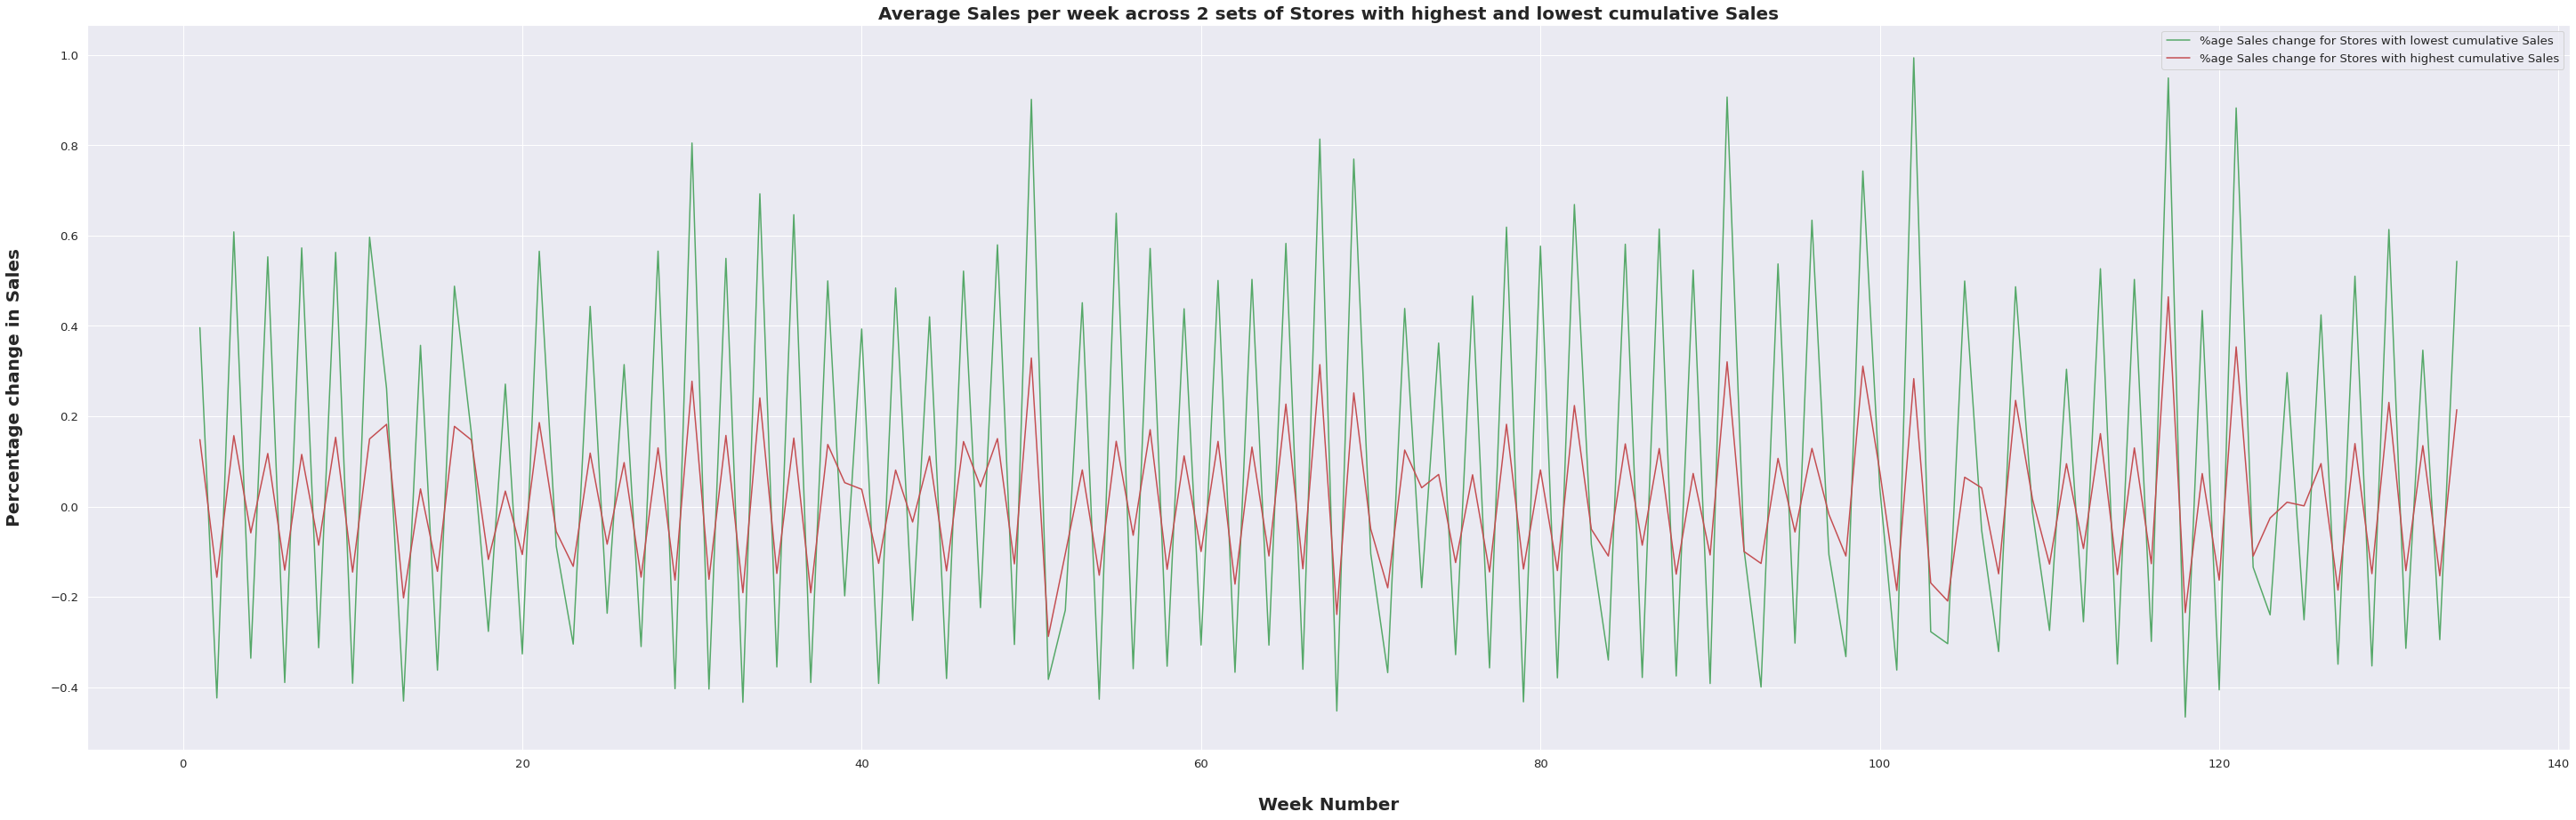

In [ ]:
#PLOT -1 (explanation at end of this question)
plt.figure(figsize=(50,15))

a = sales_per_week_low.pct_change(fill_method='ffill')
b = sales_per_week.pct_change(fill_method='ffill')

plt.plot(a['Sales'], color = 'g', label = '%age Sales change for Stores with lowest cumulative Sales')
plt.plot(b['Sales'], color = 'r', label = '%age Sales change for Stores with highest cumulative Sales')

plt.xlabel("Week Number",labelpad=30, weight='bold', size=20)
plt.ylabel("Percentage change in Sales", labelpad=30, weight='bold', size=20)
plt.title("Average Sales per week across 2 sets of Stores with highest and lowest cumulative Sales", weight='bold', size=20)
plt.legend()
plt.show()

In [ ]:
sales_per_week_low.shape, sales_per_week.shape
#number of weeks are 135 across 3 years.

((135, 2), (135, 2))

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

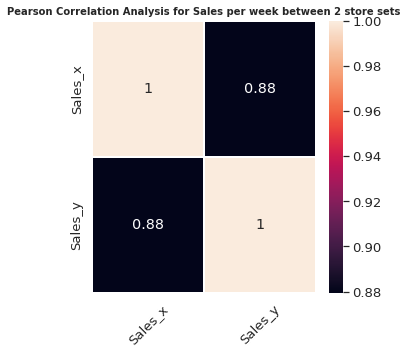

In [ ]:
sales_per_week_merged = pd.merge(sales_per_week, sales_per_week_low, how="left", on="Week")
#correlation + graph for sales
sales_corr = sales_per_week_merged[['Sales_x', 'Sales_y']].corr()
sales_corr_spear = sales_per_week_merged[['Sales_x', 'Sales_y']].corr(method ='spearman')

#Plotting heatmap usng seaborn
plt.figure(figsize = (5,5))
sns.set(font_scale = 1.2)
plot = sns.heatmap(sales_corr, annot=True, linewidths=.5)
plot.set_title("Pearson Correlation Analysis for Sales per week between 2 store sets", weight='bold', size=10)
plt.xticks(rotation=45)

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

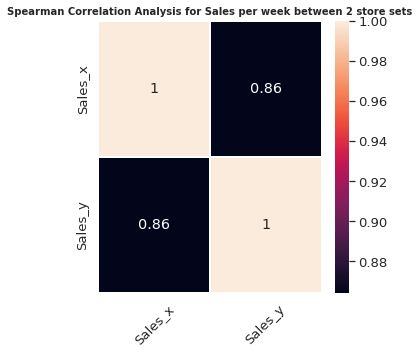

In [ ]:
plt.figure(figsize = (5,5))
sns.set(font_scale = 1.2)
plot = sns.heatmap(sales_corr_spear, annot=True, linewidths=.5)
plot.set_title("Spearman Correlation Analysis for Sales per week between 2 store sets",weight='bold', size=10)
plt.xticks(rotation=45)

**Observations:**

---

1. As expected, the claim in a) part is true. This can be interpreted with the help of correlation analysis. Correlation shows the extent to which 2 variables are similar/dissimilar to each other OR it shows whether the variables are highly correlated or negatively correlated or unrelated.
2. **The Pearson correlation value between Sales_x (i.e. the Sales of stores having highest cumulative Sales) and Sales_y (i.e. the Sales of stores having lowest cumulative Sales) is 0.88**. This shows that the Sales patterns between these 2 sets of stores are very similar.
3. **Similarly, the Spearman correlation value is 0.86.**
4. Plot #1 also shows that the lineplots are similar to each other for both highest and lowest stores. This is because I have taken percentage change and the coinciding lines explains the fact that these 2 have similar patterns for Sales.

In [ ]:
del sales_2013, sales_2014, sales_2015, sales_per_week, sales_2013_low, sales_2014_low, sales_2015_low, sales_per_week_low, sales_per_week_merged

## **Section 4: Closest Competitor: Distance and Age (Q4a & Q4b)**

**Steps performed:**

---

1. First, I have grouped 'CompetitionDistance', 'week_of_year' columns and fetched the sum of Sales for unique combinations of above 2 columns.
2. I have done #1 separately for 3 years: 2013,2014,2015 and have merged the results.
3. Finally, I have grouped the combined dataframe based on CompetitionDistance column and fetched the mean of Sales value.

**Observations:**

---

1. Here, I have plotted a scatter plot as we have 655 unique CompetitionDistance values on x-axis which will create a clutter if we plot bar/line graph.
2. From the graph, it is clear that the distance of nearest competitor doesn't impact the sales much. As we go along the x-axis i.e. the distance of the competitor increases, the 'Sales' points started to diminish with few exceptions such as Store=453 which has a competitor > 75000 metres away.
3. Interestingly, the intial behavior is opposite of #3, i.e. Stores having farther competitor have better sales till CompetitionDistance = 20000. After that, the CompetitionDistance doesn't have much impact on Sales of Stores.

**This can be attributed to the fact that customers might go to competitor stores till a certain distance (as they will have a choice and sales will depend on multiple factors such as quality of service, price of items) and after that, this field doesn't matter much (as customers will prefer to buy from a nearby store rather than travelling far away for few dollars).**

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.,  80000.]),
 <a list of 10 Text major ticklabel objects>)

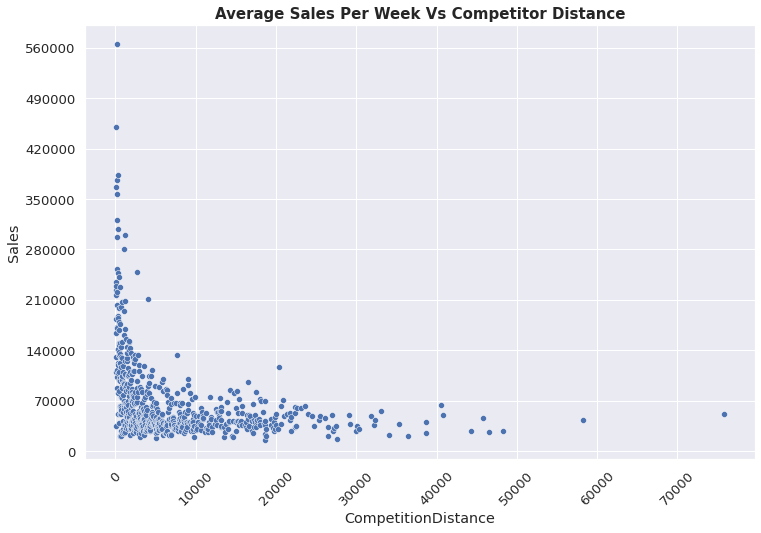

In [ ]:
sales_1 = df_preprocess[df_preprocess.year == 2013][["CompetitionDistance", "week_of_year","Sales"]].groupby(["CompetitionDistance","week_of_year"]).sum().reset_index()
sales_2 = df_preprocess[df_preprocess.year == 2014][["CompetitionDistance", "week_of_year","Sales"]].groupby(["CompetitionDistance","week_of_year"]).sum().reset_index()
sales_3 = df_preprocess[df_preprocess.year == 2015][["CompetitionDistance", "week_of_year","Sales"]].groupby(["CompetitionDistance","week_of_year"]).sum().reset_index()

sales_4 = pd.DataFrame(pd.concat([sales_1, sales_2, sales_3]))
sales_distance= pd.DataFrame(sales_4.groupby('CompetitionDistance')['Sales'].mean())

plt.figure(figsize=(12,8))
sns.set(font_scale = 1.2)
plot = sns.scatterplot(x="CompetitionDistance", y="Sales", data=sales_distance)
plot.set_title("Average Sales Per Week Vs Competitor Distance",weight='bold', size=15)
plot.set_yticks(range(0, int(sales_distance.Sales.max()), 70000))
plt.xticks(rotation=45)

## **Section 5: Pearson Correlation of Features (Q5)**

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

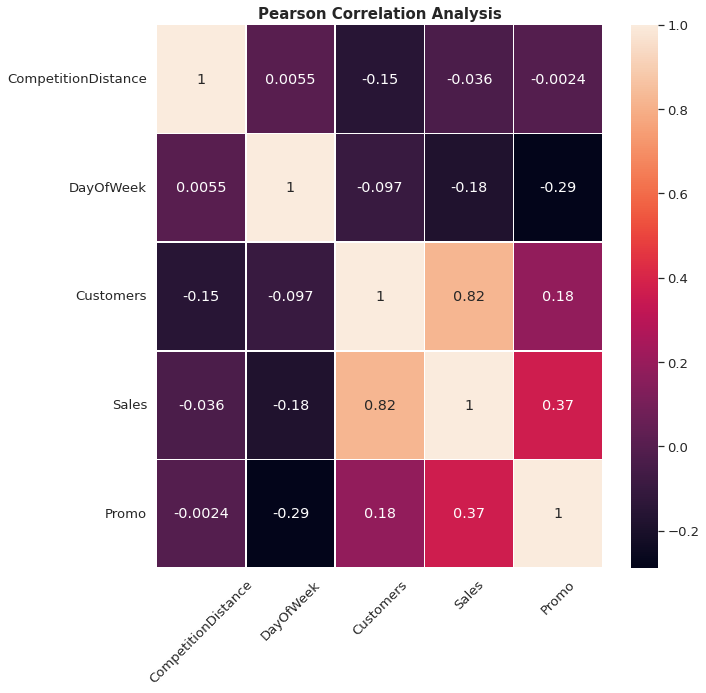

In [ ]:
import seaborn as sns
#here are the 5 interesting features:
interesting_features = ['CompetitionDistance', 'DayOfWeek','Customers','Sales','Promo']

#Calculating correlation
correlation = df_preprocess[interesting_features].corr()

#Plotting heatmap usng seaborn
plt.figure(figsize = (10,10))
sns.set(font_scale = 1.2)
plot = sns.heatmap(correlation, annot=True, linewidths=.5)
plot.set_title("Pearson Correlation Analysis",weight='bold', size=15 )
plt.xticks(rotation=45)

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

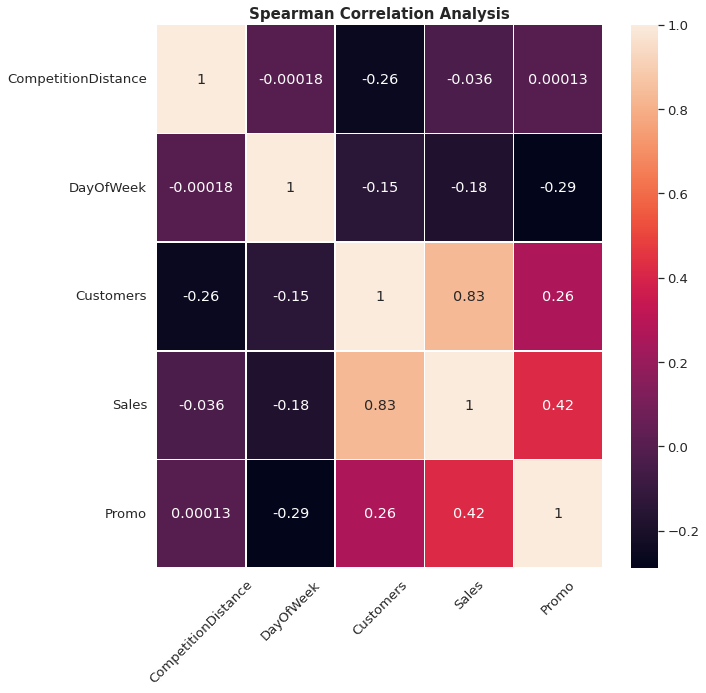

In [ ]:
correlation_spearman = df_preprocess[interesting_features].corr(method = 'spearman')

plt.figure(figsize = (10,10))
plot = sns.heatmap(correlation_spearman, annot=True, linewidths=.5)
plot.set_title("Spearman Correlation Analysis", weight='bold', size=15)
plt.xticks(rotation=45)

**Steps performed and Observations:**


---

1. Here, I have taken 5 features as: ['CompetitionDistance', 'DayOfWeek','Customers','Sales','Promo']
2. Next, I have calculated the Pearson and Spearman correlation one by one.
3. Finally, a heat map is plotted using seaborn library for visualization.

**Observations:**
My explanations are based on threshold value as 0.35 -

1. Feature-pairs with the strongest correlations are shown below: **(Sales, Customers, 0.82),(Sales, Promo, 0.37)**. This means that if the Customers increase, the Sales will definitely increase based on the current dataset. Similarly, if the Stores continue to provide Promos, then the Sales are likely to increase.
2. Correlation values of 2 columns: Customers, Promo w.r.t. Sales are greater than the threshold value. **So, Customers and Promo correlates the best with Sales.**
3. **Spearman correlation** values are quite similar to that of Pearson correlation. The strongest feature pairs are again: **(Customers, Sales,0.83) and (Promo, Sales, 0.42).**
4. Pearson correlation evaluates the linear relationship between continuous variable. This means that the value of a variable increases with respect to the other variable in a proportional manner. On the other hand, Spearman correlation evaluates the monotonic relationship between continuous variables. This means that the value of a variable increase with respect to the other variable in a non-consistent manner.


## **Section 6: Permutation Testing (Q6)**

**Below are the 3 variables used to build regression models:**
1. Customers 
2. CompetitionDistance
3. Promo

**Steps taken to perform p-test:**
- **LinearRegression** is the model used here and **sklearn.model_selection.permutation_test_score** is the function used to calculate the p-values for these variables.
- Here, I have taken log of Sales column as mentioned and used **root-mean-squared error** of the log(sale) as the statistic for scoring.
- I have also increased the permutations from **100**(default) to **200** for better results.
- Here the null hypothesis is that the above 3 features are independent of 'Sales'. The threshold for p-value can be taken as 0.05.
- If the p-values will be greater than 0.05, then we may ignore the variables as there will be no real dependency between them and results might have been predicted by chance. And if p-value is less than 0.05, then there is a real dependency between the features and predicted results.

In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
X = df_preprocess[['Customers']]
y = np.log(df_preprocess.Sales.values)
_,_, pvalue = sklearn.model_selection.permutation_test_score(reg, X, y, n_permutations= 200, scoring= 'neg_root_mean_squared_error')
print("p-value for variable 'Customers': ", pvalue)

X1 = df_preprocess[['CompetitionDistance']]
_,_, pvalue1 = sklearn.model_selection.permutation_test_score(reg, X1, y, n_permutations= 200, scoring = 'neg_root_mean_squared_error')
print("\np-value for variable 'CompetitionDistance': ", pvalue1)

X2 = df_preprocess[['Promo']]
_,_, pvalue2 = sklearn.model_selection.permutation_test_score(reg, X2, y, n_permutations= 200, scoring = 'neg_root_mean_squared_error')
print("\np-value for variable 'Promo': ", pvalue2)
#pvalue > threshold , by change otherwise all good.

p-value for variable 'Customers':  0.004975124378109453

p-value for variable 'CompetitionDistance':  1.0

p-value for variable 'Promo':  0.004975124378109453


**Observations**:

---
- p-values for these 3 variables are: 0.004975124378109453, 1.0, 0.004975124378109453
- Here the null hypothesis is that the above 3 features are independent of 'Sales'. The threshold for p-value can be taken as 0.05.
- **Now, as the p-values for variables: 'Customers' (0.004975124378109453) and 'Promo' (0.004975124378109453) are less than 0.05, we can safely reject the null hypothesis for these 2 variables. There is a real dependency between these 2 and predicted 'Sales' and it is not by chance.**
- On the other hand, p-value for variable 'CompetitionDistance' (1.0) > 0.05 which means there is a lack of dependency with 'Sales' column and if we remove this column, we may get better prediction results.

## **Section 7: Interesting findings (Q7)**

**Interesting plot 1**

---
- In this plot, I tried to check for the reason behind low sales on Day 7.
- As evident from the graph, it is clear that the Stores are closed on Day 7, probably due to Sunday. Hence, the Sales are very minimal as compared to other days.
- Another interesting thing to note here is that the Sales tend to increase from mid-week i.e. Day 4 to Day 6 (before the day Stores are closed). Generally, human beings has the tendency to purchase things before holidays so that they don't run out of stock during holidays.


Text(0, 0.5, 'Sales')

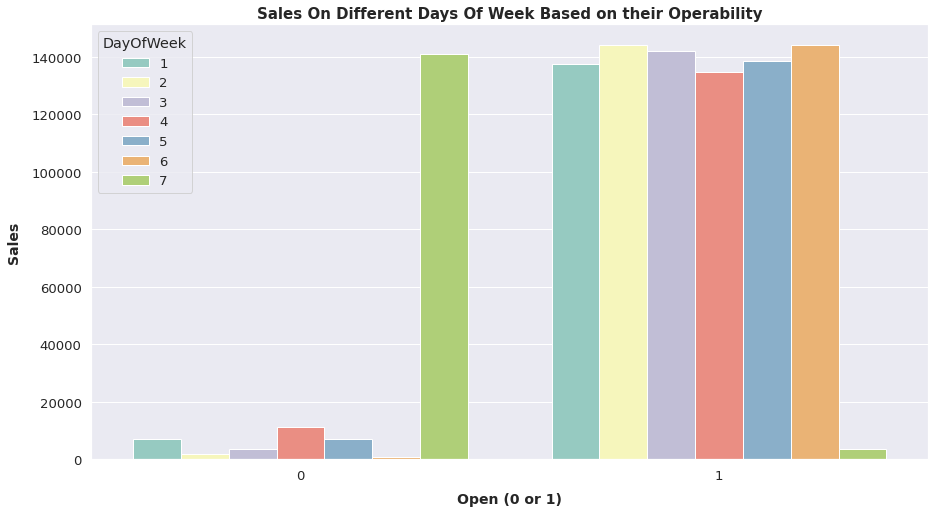

In [ ]:
plt.figure(figsize = (15,8))
sns.set(font_scale = 1.2)
plot = sns.countplot(x='Open', hue='DayOfWeek', data=df_merged, palette='Set3')
plot.set_title("Sales On Different Days Of Week Based on their Operability",weight='bold', size=15 )
plot.set_xlabel("Open (0 or 1)", labelpad=10, weight='bold', size=14)
plot.set_ylabel("Sales", labelpad=10, weight='bold', size=14)

**Interesting Plot 2**

---

- Here, I have plotted a histogram distribution for Sales data after grouping it based on CompetitionDistance. 
- In this plot, we can see that the graph is right-skewed i.e. most of the sales values lies on the left side of the graph. This suggests that if the nearest competitor is far away, then it has minimal impact on the Sales. Most of the Sales values were for stores that had nearby competitors. This might be because the stores are looking to provide best quality products and services to their customers as they are aware of the fact that their customers can easily go to other competitors nearby. Hence, sales have been more in that part.
- Another reason can be the location of Customers i.e. most of the customers will prefer to buy goods from the stores nearest to their residences.

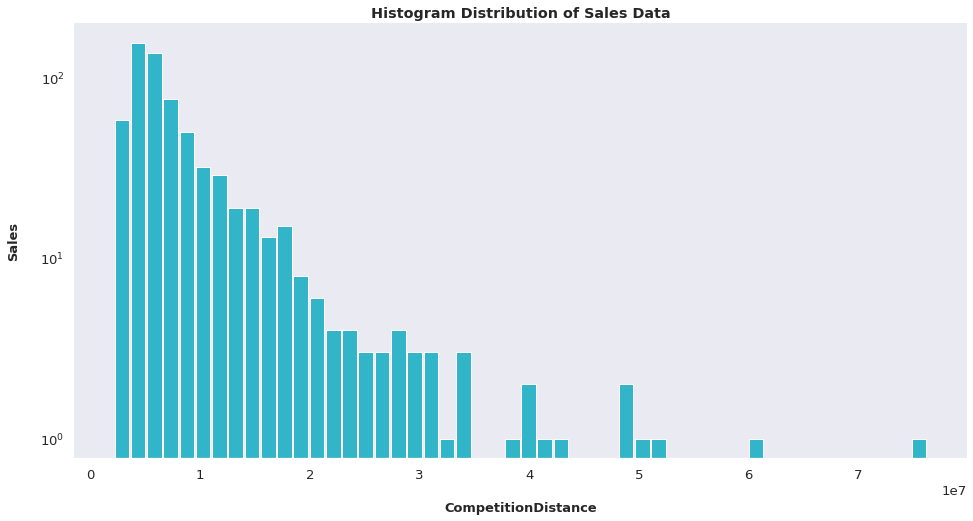

In [ ]:
sales_competition = df_preprocess[["CompetitionDistance", "Sales"]].groupby("CompetitionDistance").sum().reset_index()
ax = sales_competition.hist(column='Sales', bins=50, grid=False, log=True,
                        figsize=(16,8), color="#32B5C9", rwidth=0.9
                        )
ax = ax[0]
for x in ax:
    x.set_title("Histogram Distribution of Sales Data", weight='bold')
    x.set_xlabel("CompetitionDistance", labelpad=20, weight='bold', size=13)
    x.set_ylabel("Sales", labelpad=20, weight='bold', size=13)
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

**Interseting Plot 3**

---

- In this box plot, I have explored the Sales with respect to the categorical features of our dataset. The columns analyzed here are: 'StateHoliday', 'StoreType', 'Assortment'.
- In first plot, there is an indication that the Sales are higher during Easter Holidays than any other holiday. This can be due to the reason that Easter holidays are longer than Christmas(2 days) and public holidays(1 day).
- In second plot, it can be noticed that Stores with type 'b' have higher Sales than the other other 3: 'a', 'c', 'd'. Along with this, there are many outliers above maximum which can make this column insignificant in prediction analysis.
- In Third plot, the graph shows that the Stores with assortment level of type 'b' i.e. Extra have the higher Sales than the other 2 assortment levels. Moreover, the outliers for 'b' are pretty trivial as compared to other 2 levels.



Text(0, 0.5, 'Sales')

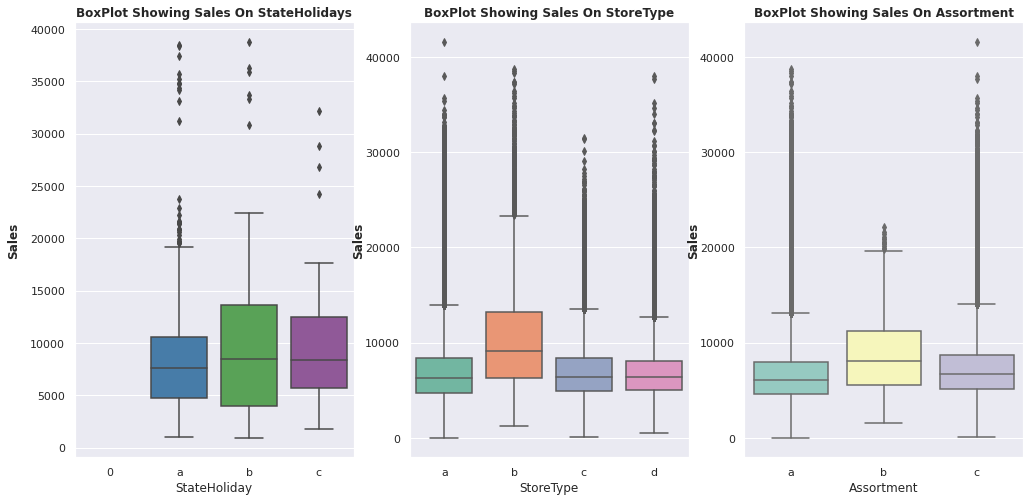

In [ ]:
plt.figure(figsize = (17,8))
sns.set(font_scale = 1)
plt.subplot(1, 3, 1)
plot1 = sns.boxplot(x="StateHoliday", y="Sales", data=df_preprocess[df_preprocess.StateHoliday !=  '0'], palette='Set1')
plot1.set_title("BoxPlot Showing Sales On StateHolidays", weight='bold', size=12 )
plot1.set_ylabel("Sales", labelpad=10, weight='bold', size=12)

plt.subplot(1, 3, 2)
plot2 = sns.boxplot(x="StoreType", y="Sales", data=df_preprocess, palette='Set2')
plot2.set_title("BoxPlot Showing Sales On StoreType", weight='bold', size=12 )
plot2.set_ylabel("Sales", labelpad=0, weight='bold', size=12)

plt.subplot(1, 3, 3)
plot3 = sns.boxplot(x="Assortment", y="Sales", data=df_preprocess, palette='Set3')
plot3.set_title("BoxPlot Showing Sales On Assortment", weight='bold', size=12 )
plot3.set_ylabel("Sales", labelpad=0, weight='bold', size=12)

**Interesting Plot 4**

---
- This is a scatter plot between Customers and Sales based on different days of week. Here, we can see that the Sales are increasing as the number of customers are increasing for every week day.
- Interestingly, there are few dots after Sales=34000 which are red(Day1) and maroon(Day7) in color.
- We are also aware of the fact that on Day7, most of the stores are closed and Sales are negligible on that day. Thus, these might be unique cases OR outliers that can be taken out before training the model.
- Another interesting thing about this plot is the blue mark(Day 2) between 25000 and 30000 Sales mark (on top right). A lot of customers came to the stores for purchasing things on that day and the Sales were on the higher side as expected. Probably, this day is before a stateholiday and people are looking to buy things before that.

Text(0.5, 0, 'Sales')

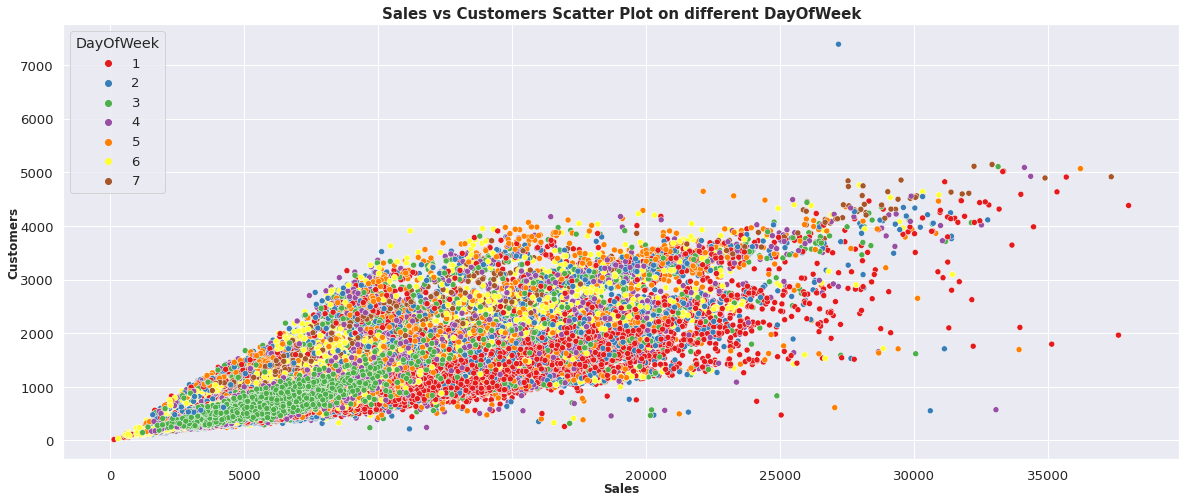

In [ ]:
# Scatter plot
plt.figure(figsize=(20,8))
sns.set(font_scale = 1.2)
plot = sns.scatterplot(x='Sales',y='Customers',data=df_preprocess[df_preprocess.year == 2013],hue='DayOfWeek',palette='Set1')
plot.set_title("Sales vs Customers Scatter Plot on different DayOfWeek",weight='bold', size=15)
plot.set_ylabel("Customers", labelpad=0, weight='bold', size=12)
plot.set_xlabel("Sales", labelpad=0, weight='bold', size=12)

**Interesting Plot 5**

---



Here, I have considered the dataset for year 2013 only to avoid clutter. This plot shows that the Sales have been fluctuating every month. Percentage change before holidays are higher than usual change and during holidays, it decreases. This means the Sales are low on holidays as expected.


Plotted line graph


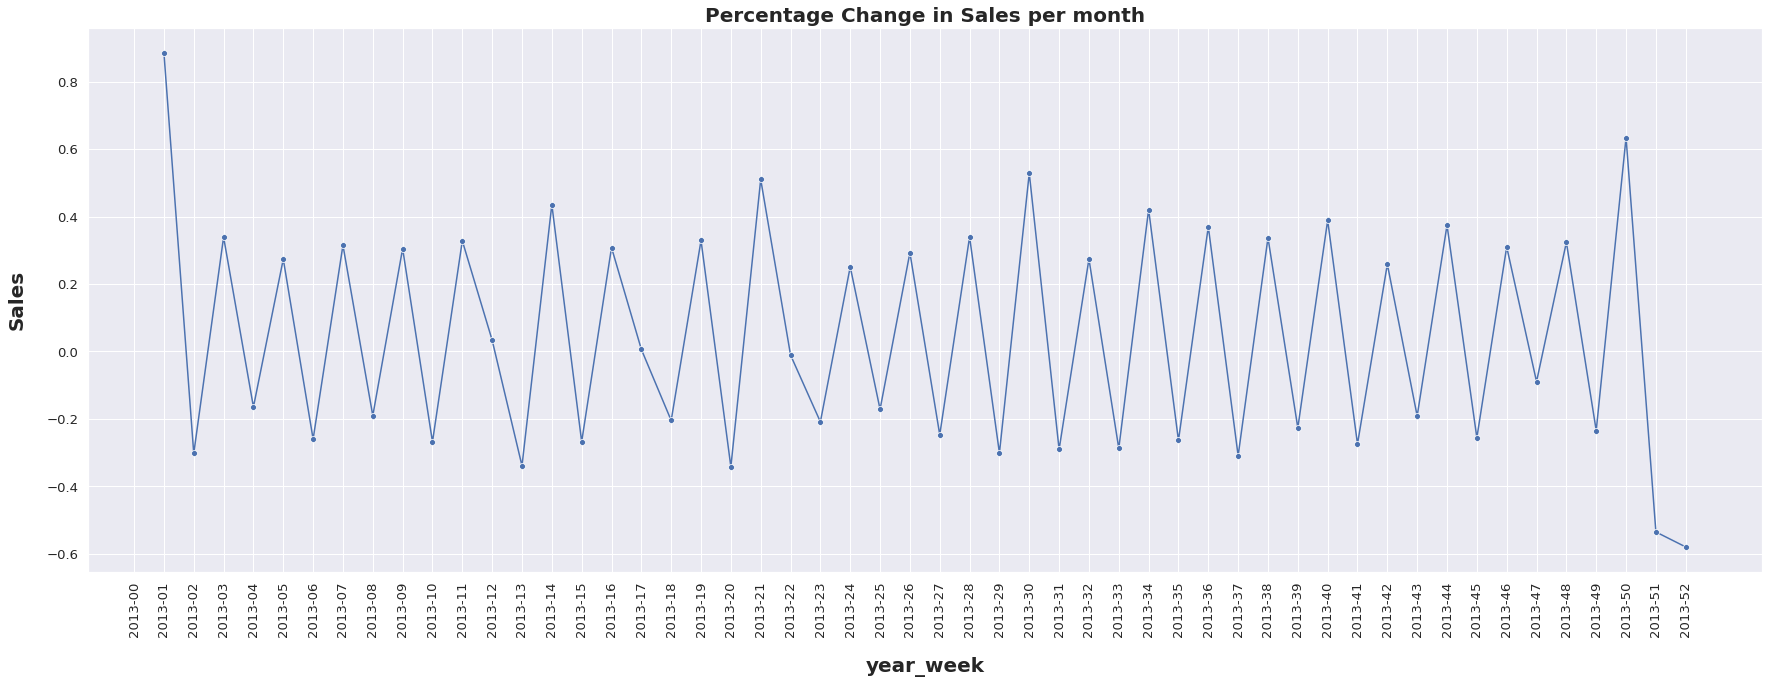

In [ ]:
#Line Plot
percentage_change_sales_per_day = df_preprocess[df_preprocess.year == 2013].groupby('year_week')["Sales"].sum().pct_change()
ab = pd.DataFrame(percentage_change_sales_per_day)

plt.figure(figsize=(30,10))
sns.set(font_scale = 1.2)
plot = sns.lineplot(x="year_week", y="Sales",marker='o', data=ab)
plot.set_title("Percentage Change in Sales per month",weight='bold', size=20)
plot.set_xlabel("year_week", labelpad=20, weight='bold', size=20)
plot.set_ylabel("Sales", labelpad=20, weight='bold', size=20)
#plot.set_yticks(range(3000, int(ab.Sales.max()), 70000))
plt.xticks(rotation=90)

print('Plotted line graph')

## **Section 8: Train Test Split and Modelling (Q8)**

**MODEL 1 - Linear Regression**

**MODEL 2 - XGBoost**


---
**STEPS TAKEN FOR THIS QUESTION:**

1) First, I have done the required preprocessing and the splitting of training dataset.

2) After that, I'll be running the 2 models for 3 different hyperparameters each. 

3) Finally, I have compared the resuts based on RMSPE values.

**1. PREPROCESSING (Please Find prior preprocessing steps at the end of Question 1)**

---



In [ ]:
#del df_for_model1
df_for_model1 = df_preprocess.copy()

In [ ]:
'''
Please note, I have only done the leftover necessary preprocessing for this dataset. Much of the preprocessing has been already done at the start
(such as removing nan values, removing 0 sales, encoding categorical PromoInterval column.)
'''
#dropping columns that were made for initial analysis based on date
drop_cols = [ 'Customers', 'year', 'day', 'month', 'year_week', 'StateHoliday', 'StoreType', 'Assortment','week_of_year']
df_for_model1 = df_for_model1.drop( drop_cols, axis=1 )

#Moving the Sales column at the end just to make slicing easier
temp_sales = df_for_model1['Sales']
df_for_model1 = df_for_model1.drop(['Sales'], axis=1)
df_for_model1['Sales'] = temp_sales
del temp_sales

**2. SPLITTING OF DATASET**

---



In [ ]:
# training dataset containing data before 2015-04-30
df_train = df_for_model1[(df_for_model1['Date'] <= '2015-04-30')]
df_train = df_train.drop(['Date'], axis=1)
x_train = df_train.iloc[:,:-1]
y_train = df_train['Sales']

# test dataset containing data from 2015-05-01 to 2015-07-31
df_test = df_for_model1[(df_for_model1['Date'] > '2015-04-30') & (df_for_model1['Date'] < '2015-08-01')]
df_test = df_test.drop(['Date'], axis=1)
x_test = df_test.iloc[:, :-1]
y_test = df_test['Sales']

In [ ]:
# RMSPE function
def rmspe(y_actual, y_pred):
    return np.sqrt(np.mean(((y_actual - y_pred) / y_actual) ** 2))

In [ ]:
del df_train, df_test

**3. MODEL -1 : MODELLING VIA RANDOM FOREST REGRESSOR**

---

**HyperParameters Used For Random Forest Regressor:**

- **n_estimators**: This parameter specifies the number of trees in the forest. Higher value for n_estimators can give better prediction results but it will slow down the model. So, value should be high but only as high as the processor can handle it.
- **max_depth**: This parameter specifies the maximum depth of the tree. This is an important parameter in controlling the memory consumption in check. If it is not specified, then tree continues to grow unless all leaf nodes are pure.
- **min_samples_leaf**: This parameter specifis the minimum number of samples required to be at a leaf node. Greater value for this results in better prediction results. Smaller values can make the model prone to noisy data.

After running all the models, I have explained the observations and comparisons between each model run.

In [ ]:
#Hyperparameter setting -1
#Runtime 20 seconds
clf_random = RandomForestRegressor(n_estimators=50, max_depth = 1, min_samples_leaf=50)
clf_random.fit(x_train, y_train)
preds = clf_random.predict(x_test)
print("Calculating the Root Mean Percentage Square for Random Forest regressor with Hyperparameters set 1: ", rmspe(y_test, preds))

Calculating the Root Mean Percentage Square for Random Forest regressor with Hyperparameters set 1:  0.46535697345864396


In [ ]:
#Hyperparameter setting -2
#Runtime 3 mins
clf_random = RandomForestRegressor(n_estimators=100, max_depth = 10, min_samples_leaf=50)
clf_random.fit(x_train, y_train)
preds_1 = clf_random.predict(x_test)
print("Calculating the Root Mean Percentage Square for Random Forest regressor with Hyperparameters set 2: ", rmspe(y_test, preds_1))

Calculating the Root Mean Percentage Square for Random Forest regressor with Hyperparameters set 2:  0.35295785463475265


In [ ]:
#Hyperparameter setting -3
#Runtime 4 mins 
clf_random = RandomForestRegressor(n_estimators=100, max_depth = 12, min_samples_leaf=70)
clf_random.fit(x_train, y_train)
preds_2 = clf_random.predict(x_test)
print("Calculating the Root Mean Percentage Square for Random Forest regressor with Hyperparameters set 3: ", rmspe(y_test, preds_2))

Calculating the Root Mean Percentage Square for Random Forest regressor with Hyperparameters set 3:  0.30284971331032234


In [ ]:
a = {'HyperParameter Settings' : [1,2,3], 'n_estimators' : [50,100,100],'max_depth' : [1,10,12],
     'min_samples_leaf' : [50,50,70] , 'RMSPE Values': [0.46535697345864396,0.35295785463475265, 0.30284971331032234],
     'Runtime (in mins)' : [0.3,3,4.5]}
d = pd.DataFrame(a)
d.set_index('HyperParameter Settings', inplace=True)
d

,n_estimators,max_depth,min_samples_leaf,RMSPE Values,Runtime (in mins)
HyperParameter Settings,,,,,
1,50,1,50,0.465357,0.3
2,100,10,50,0.352958,3.0
3,100,12,70,0.302850,4.5


**OBSERVATIONS FOR DIFFERENT HYPERPARAMETER SETTINGS FOR XGBOOST REGRESSOR:**

---
1. From the above table, we can see that on increasing the n_estimators and max_depth values, the RMSPE value is getting reduced and thus, in this case the last run with hyperparameter setting as 3 seems to be best one. This is expected because higher value of n_estimators will provide more number of trees and thus model can be trained better.

2. Please note, with increase in accuracy, model is also taking more time to produce results as these parameters are increased. This may be attributed to the fact that model has to traverse a larger tree and have to check for a greater depth of tree. So, it'll require more computational time and effort as compared to the first model.

**MODEL -2 Modelling via XGBoost Regressor**

---
**HyperParameters Used For XGBoost Regressor:**

1. **objective**: This parameter specifies the learning objective. Here, **I have used squarederror as objective**. We don't have any requirements of labels being greater than -1 as is required in squaredlogerror objective.

2. **eta:** ETA (Or learning rate) is used to shrink the feature weights to make the boosting process more conservative. Here, I have used eta value as 0.01.

3. **max_depth:** This parameter is the Maximum depth of a tree. Here, I have used max_depth as 12, 8, and 5.

After running all the models, I have explained the observations and comparisons between each model run.


In [ ]:
#Hyperparameter setting -1 
#runtime 4 mins
xgbr = XGBRegressor(objective='reg:squarederror', 
                    n_estimators=120, 
                    eta=0.01, 
                    max_depth=12
                    )

xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=120,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
#predicting the sales values and calculating the RMSPE.
y_pred_2 = xgbr.predict(x_test)
print("Calculating the Root Mean Percentage Square for XGBoost regressor with Hyperparameters set 1: ", rmspe(y_test, y_pred_2))

Calculating the Root Mean Percentage Square for XGBoost regressor with Hyperparameters set 1:  0.15681058339064807


In [ ]:
#Hyperparameter setting - 2
#runtime 2 minutes
xgbr = XGBRegressor(objective='reg:squarederror', 
                    n_estimators=120, 
                    eta=0.01, 
                    max_depth=8
                    )

xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=120,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
#predicting the sales values and calculating the RMSPE.
y_pred_2_1 = xgbr.predict(x_test)
print("Calculating the Root Mean Percentage Square for XGBoost regressor with Hyperparameters set 2: ", rmspe(y_test, y_pred_2_1))

Calculating the Root Mean Percentage Square for XGBoost regressor with Hyperparameters set 2:  0.2096603637367919


In [ ]:
#Hyperparameter settings -3 
#runtime 1 min 
xgbr = XGBRegressor(objective='reg:squarederror', 
                    n_estimators=120, 
                    eta=0.01, 
                    max_depth=5)

xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=120,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
#predicting the sales values and calculating the RMSPE.
y_pred_2_2 = xgbr.predict(x_test)
print("Calculating the Root Mean Percentage Square for XGBoost regressor with Hyperparameters set 3: ", rmspe(y_test, y_pred_2_2))

Calculating the Root Mean Percentage Square for XGBoost regressor with Hyperparameters set 3:  0.32631884478815903


In [ ]:
a = {'HyperParameter Settings' : [1,2,3], 'objective' : ['squarederror','squarederror','squarederror'],'Learning_rate(eta)' : [0.01,0.01,0.01],
     'max_depth' : [12,8,5] , 'RMSPE Values': [0.15681058339064807, 0.2096603637367919, 0.32631884478815903],
     'Runtime (in mins)' : [5,2,1]}
d = pd.DataFrame(a)
d.set_index('HyperParameter Settings', inplace=True)
d

,objective,Learning_rate(eta),max_depth,RMSPE Values,Runtime (in mins)
HyperParameter Settings,,,,,
1,squarederror,0.01,12,0.156811,5
2,squarederror,0.01,8,0.209660,2
3,squarederror,0.01,5,0.326319,1


**OBSERVATIONS FOR DIFFERENT HYPERPARAMETER SETTINGS FOR XGBOOST REGRESSOR:**

---
1. From the above table, we can see that on increasing the max_depth value, the RMSPE value is getting reduced and thus, in this case the first run seems to the better one.
2. Another thing to note here is that the runtime of the model increases as the max_depth increases. This is expected because now the model has to go deeper into the tree and will require more training effort. 


## **Section 9: t-test (Q9)**

In this question, I have considered the best run of each model and then performed a ttest using scipy module.

**Best run of MODEL -1 (Random Forest Regressor):** Hyperparameter-3 (RMSPE: 0.302850)

**Best run of MODEL -2 (XGBoost Regressor):** Hyperparameter-1 (RMSPE: 0.156811)

**Observations:**
- First thing to notice here is that the best run of Random Forest is far behind the XGBoost model. This can be seen w.r.t. RMSPE values.
- Here the p-value computed by the ttest is 0.35 which is greater than the threshold value of 0.05. This means that the results from the models are **statistically similar** and there aren't any significant differences between the two.

In [ ]:
import scipy
#from scipy import stats
scipy.stats.ttest_ind(preds_2, y_pred_2)

# statistically similar if p value is > 0.05

Ttest_indResult(statistic=0.9207291228562897, pvalue=0.35719318182866444)

## **Section 10: Screenshots (Q10)** 

**Here, I have first predicted the results based on best of RandomForest models and then predicted the results based on best of XGBoost models. XGBoost has performed well as compared to RandomForest and the final Kaggle scores have been reported for both the models in the screenshot.**

In [ ]:
df_test_data = pd.read_csv('/content/drive/MyDrive/CSE 519 - Fall 2021/Assignment-3/test.csv.zip')
test_store = pd.merge( df_test_data, df_store_data, how='left', on='Store' )

In [ ]:
drop_cols = [ 'Id', 'Date', 'StateHoliday', 'StoreType', 'Assortment']
test_store = test_store.drop( drop_cols, axis=1 )
test_store['CompetitionDistance'] = test_store['CompetitionDistance'].fillna(test_store['CompetitionDistance'].mean())
test_store.loc[test_store['Promo2'] == 0, ['Promo2SinceWeek', 'Promo2SinceYear']] = 0
test_store['CompetitionOpenSinceMonth'] = test_store['CompetitionOpenSinceMonth'].fillna(0)
test_store['CompetitionOpenSinceYear'] = test_store['CompetitionOpenSinceYear'].fillna(0)
category_encoding(test_store, 'PromoInterval')

categorical column: PromoInterval


In [ ]:
test_store = test_store.fillna(0)
test_store.isnull().sum()

Store                        0
DayOfWeek                    0
Open                         0
Promo                        0
SchoolHoliday                0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [ ]:
final_random_forest = clf_random.predict(test_store)

In [ ]:
final_xgb = xgbr.predict(test_store)

In [ ]:
submission = pd.DataFrame({'Id': df_test_data['Id'], 
                               'Sales': final_random_forest})

submission.to_csv("/content/drive/MyDrive/CSE 519 - Fall 2021/Assignment-3/random_forest.csv", index=False)

In [ ]:
submission_1 = pd.DataFrame({'Id': df_test_data['Id'], 
                               'Sales': final_xgb})

submission_1.to_csv("/content/drive/MyDrive/CSE 519 - Fall 2021/Assignment-3/XGB.csv", index=False)

**Public Score :** 0.15611

**Private Score :**  0.16839

**Kaggle profile link:** https://www.kaggle.com/goeldinker

**Total number of submissions:** 2

**Screenshot:**

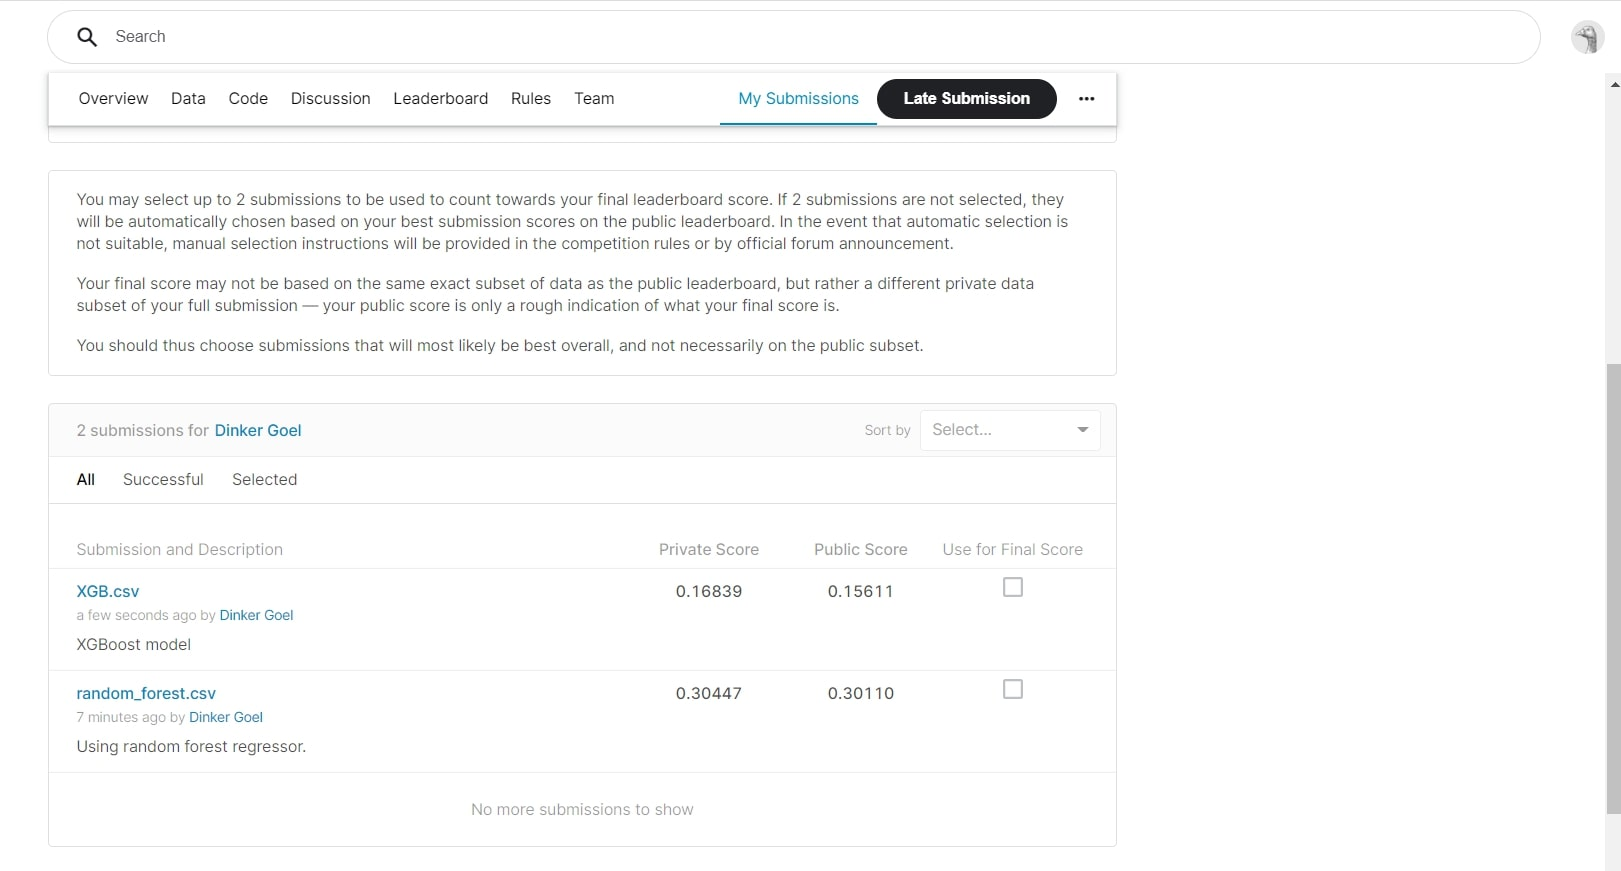

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Kaggle_submission_screenshot.jpg')